<a href="https://colab.research.google.com/github/Cheese-5040/OCT-Scan-Segmentation/blob/main/better_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [4]:
import os
import random 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange #basically pakage that show progress bar in loops
from itertools import chain #function used to create efficient looping in python

#package used for image processing
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

from keras.models import Model, load_model
#input is used to instantiate a keras tensor
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, Concatenate
from keras.layers import Lambda, RepeatVector, Reshape  # Fixed import
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D, concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #save weights at some freq, reduce learning rate when metric stop improving
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import normalize, to_categorical

# import matplotlib.image as mpimg
import cv2 
# from google.colab.patches import cv2_imshow

In [7]:
!pip install --upgrade tqdm


  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1


In [8]:
from tqdm.notebook import tqdm




#dock to drive + set params for width and height 

In [5]:
im_width = 128
im_height = 128
border =5
n_classes = 6

In [6]:
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


#getting image and mask data

In [18]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.io import imread

# Parameters for image resizing
im_height = 128
im_width = 128

# Function to get images and masks
def get_image_mask(all_patients):
    train_images = []
    train_masks = []
    index = 0
    for N, patient in tqdm(enumerate(all_patients), total=len(all_patients)):
        PATIENT_PATH = "./extracted_files_martina/AROI - online/24 patient/" + str(patient)
        
        # Check if the patient path is a valid directory
        if not os.path.isdir(PATIENT_PATH):
            print(f"Skipping {PATIENT_PATH} as it is not a valid directory")
            continue
        
        pic_ids = [f for f in os.listdir(PATIENT_PATH + "/raw/labeled") if not f.startswith('.')]
        print(f"No. of images for patient {patient} = {len(pic_ids)}")
        
        for id_ in pic_ids:
            # Construct image and mask paths
            img_path = PATIENT_PATH + "/raw/labeled/" + id_
            mask_path = PATIENT_PATH + "/mask/number/" + id_

            # Check if paths are valid files
            if not os.path.isfile(img_path) or not os.path.isfile(mask_path):
                print(f"Skipping invalid file: {id_}")
                continue

            # Load and resize image
            img = imread(img_path, as_gray=True)
            img = cv2.resize(img, (im_height, im_width))
            train_images.append(img)

            # Load and resize mask
            mask = imread(mask_path, as_gray=True)
            mask = cv2.resize(mask, (im_height, im_width))
            train_masks.append(mask)
            index += 1
    
    print("Total images:", index)
    return train_images, train_masks


# Directory containing all patient folders
ALL_PATIENT = "./extracted_files_martina/AROI - online/24 patient"

# Filter out hidden files like .DS_Store
patients = [p for p in os.listdir(ALL_PATIENT) if not p.startswith('.')]
print("Patients:", patients)

# Get images and masks
T_image, T_mask = get_image_mask(patients)

# Convert to numpy arrays
T_image = np.array(T_image)
T_mask = np.array(T_mask)

print("Final image array shape:", T_image.shape)
print("Final mask array shape:", T_mask.shape)


Patients: ['patient23', 'patient2', 'patient9', 'patient20', 'patient12', 'patient8', 'patient6', 'patient22', 'patient21', 'patient5', 'patient13', 'patient7', 'patient17', 'patient18', 'patient15', 'patient3', 'patient16', 'patient4', 'patient11', 'patient10', 'patient24', 'patient1', 'patient19', 'patient14']


  0%|                                                                                                                                            | 0/24 [00:00<?, ?it/s]

No. of images for patient patient23 = 31


  4%|█████▌                                                                                                                              | 1/24 [00:00<00:08,  2.64it/s]

No. of images for patient patient2 = 68


  8%|███████████                                                                                                                         | 2/24 [00:01<00:14,  1.54it/s]

No. of images for patient patient9 = 73


 12%|████████████████▌                                                                                                                   | 3/24 [00:02<00:15,  1.32it/s]

No. of images for patient patient20 = 66


 17%|██████████████████████                                                                                                              | 4/24 [00:02<00:15,  1.28it/s]

No. of images for patient patient12 = 19


 21%|███████████████████████████▌                                                                                                        | 5/24 [00:03<00:11,  1.71it/s]

No. of images for patient patient8 = 71


 25%|█████████████████████████████████                                                                                                   | 6/24 [00:04<00:12,  1.46it/s]

No. of images for patient patient6 = 36


 29%|██████████████████████████████████████▌                                                                                             | 7/24 [00:04<00:10,  1.65it/s]

No. of images for patient patient22 = 31


 33%|████████████████████████████████████████████                                                                                        | 8/24 [00:04<00:08,  1.87it/s]

No. of images for patient patient21 = 21


 38%|█████████████████████████████████████████████████▌                                                                                  | 9/24 [00:05<00:06,  2.22it/s]

No. of images for patient patient5 = 49


 42%|██████████████████████████████████████████████████████▌                                                                            | 10/24 [00:05<00:06,  2.00it/s]

No. of images for patient patient13 = 30


 46%|████████████████████████████████████████████████████████████                                                                       | 11/24 [00:06<00:05,  2.18it/s]

No. of images for patient patient7 = 103


 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 12/24 [00:07<00:08,  1.41it/s]

No. of images for patient patient17 = 21


 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 13/24 [00:07<00:06,  1.75it/s]

No. of images for patient patient18 = 61


 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 14/24 [00:08<00:06,  1.59it/s]

No. of images for patient patient15 = 97


 62%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 15/24 [00:09<00:07,  1.25it/s]

No. of images for patient patient3 = 20


 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 16/24 [00:09<00:05,  1.58it/s]

No. of images for patient patient16 = 49


 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 17/24 [00:10<00:04,  1.60it/s]

No. of images for patient patient4 = 56


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 18/24 [00:11<00:03,  1.55it/s]

No. of images for patient patient11 = 21


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 19/24 [00:11<00:02,  1.89it/s]

No. of images for patient patient10 = 87


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 20/24 [00:12<00:02,  1.44it/s]

No. of images for patient patient24 = 33


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21/24 [00:12<00:01,  1.64it/s]

No. of images for patient patient1 = 41


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 22/24 [00:13<00:01,  1.71it/s]

No. of images for patient patient19 = 21


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23/24 [00:13<00:00,  2.05it/s]

No. of images for patient patient14 = 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.71it/s]

Total images: 1136
Final image array shape: (1136, 128, 128)
Final mask array shape: (1136, 128, 128)


In [19]:
#clean up T_mask abit
#since class7 & 8 is very very rare, we will group them together
print(T_mask.ndim)
for i in range(len(T_mask)):
    for j in range(im_width):
      for k in range(im_height):
        T_mask[i][j][k] = 5 if T_mask[i][j][k]>5 else T_mask[i][j][k]
np.unique(T_mask[0])

3


array([0, 1, 2, 3, 4, 5], dtype=uint8)

shape of images (128, 128)
num images : 1136
shape of mask (128, 128)
num mask : 1136
num_classes : [0 1 2 3 4 5]


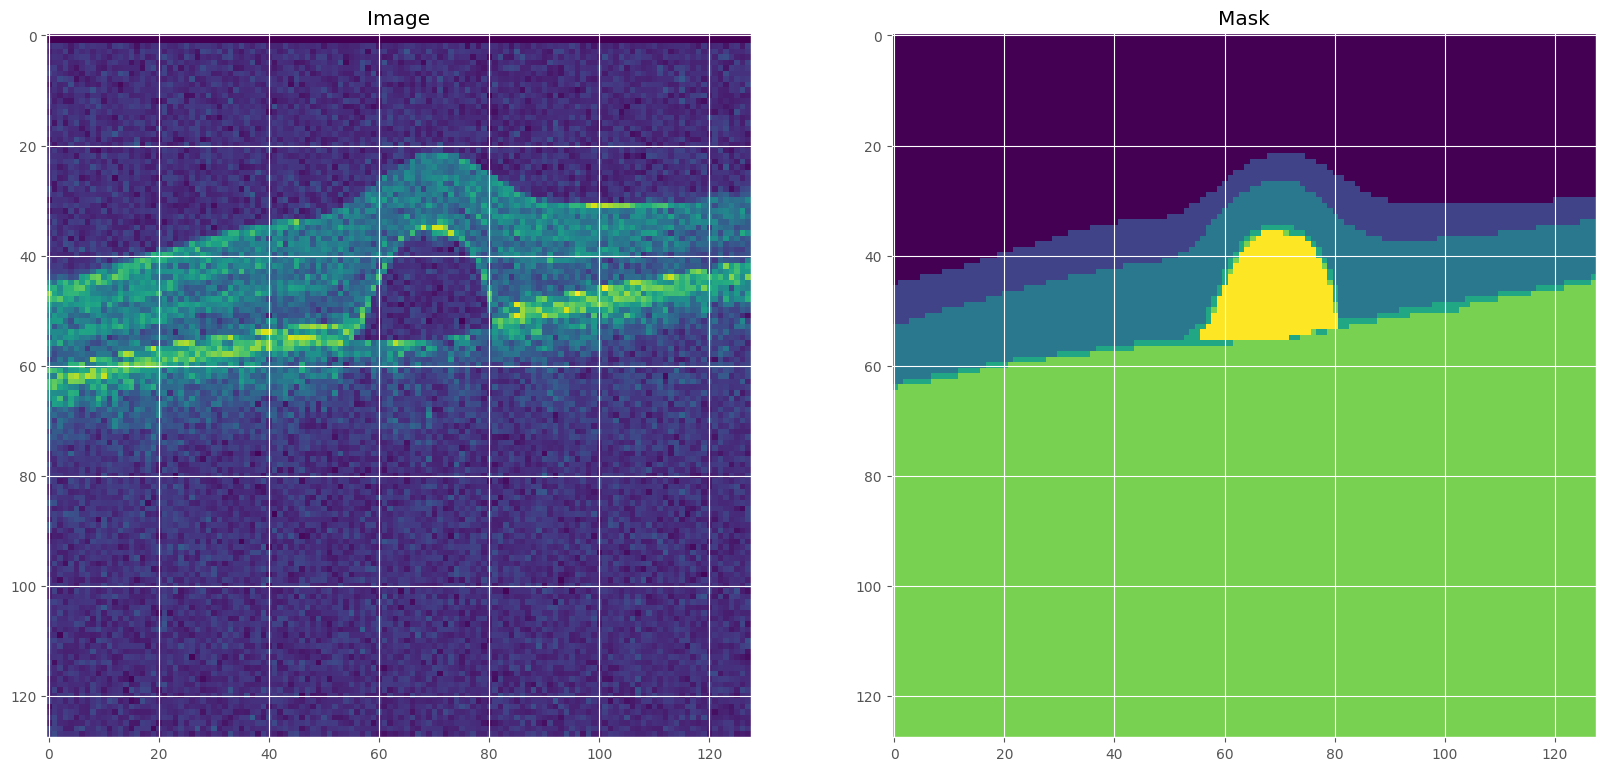

In [20]:
import random
#print random mask 
def show_img_and_mask(img, mask):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,15))
    ax1.set_title("Image")
    ax1.imshow(img)
    ax2.set_title("Mask")
    ax2.imshow(mask)

def print_mask(mask):
  with np.printoptions(threshold=np.inf):
      print(mask)

def shape_info(images, masks):
    print(f"shape of images {images[0].shape}")
    print(f"num images : {len(images)}")
    print(f"shape of mask {masks[0].shape}")
    print(f"num mask : {len(masks)}")
    print(f"num_classes : {np.unique(masks)}")

shape_info(T_image, T_mask)

rand_num = random.randint(0, len(T_image))
show_img_and_mask(T_image[rand_num], T_mask[rand_num])


# ensuring that mask is encoded properly


In [22]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# Optional step: just ensuring that the classes are 0-5 consecutively and no number skipped
# Get the shape of train_masks, number, height, width
n, h, w = T_mask.shape

# Reshape train mask to one single vector (n*im_height * im_width,)
T_masks_reshaped = T_mask.reshape(-1, 1).ravel()  # Ensure it's 1D using ravel()

# Encode target label values from 0 to n_classes-1
T_masks_reshaped_encoded = labelencoder.fit_transform(T_masks_reshaped)

# Change back the shape to ensure no overlap between classes / skipped numbers
T_masks_encoded_original_shape = T_masks_reshaped_encoded.reshape(n, h, w)

# Print shapes and unique values
print("Reshaped T_mask shape:", T_masks_reshaped.shape)
print("Encoded T_mask shape:", T_masks_encoded_original_shape.shape)
print("Unique values in encoded masks:", np.unique(T_masks_encoded_original_shape))


Reshaped T_mask shape: (18612224,)
Encoded T_mask shape: (1136, 128, 128)
Unique values in encoded masks: [0 1 2 3 4 5]


#normalizing data + processing + reshaping


In [23]:
train_images = np.expand_dims(T_image, axis = 3)
train_images = normalize(train_images, axis = 1)
train_masks_input = np.expand_dims(T_masks_encoded_original_shape, axis=3)

print(f"shape of train_images : {train_images.shape}")
print(f"shape of train_masks_input : {train_masks_input.shape}")

shape of train_images : (1136, 128, 128, 1)
shape of train_masks_input : (1136, 128, 128, 1)


In [24]:
'''double split to train'''
#10% testing, 90% training 
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(f"shape of X1 : {X1.shape}")
print(f"shape of X_test : {X_test.shape}")
print(f"shape of y1 : {y1.shape}")
print(f"shape of y_test : {y_test.shape}")
#Further split training data t a smaller subset for quick testing of models (20% test, 90% train)
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)
print(f"classes num in dataset are: {np.unique(y_train)}")
print(f"shape of X_train : {X_train.shape}")
print(f"shape of X_do_not_use : {X_do_not_use.shape}")
print(f"shape of y_train : {y_train.shape}")
print(f"shape of y_do_not_use : {y_do_not_use.shape}")


shape of X1 : (1022, 128, 128, 1)
shape of X_test : (114, 128, 128, 1)
shape of y1 : (1022, 128, 128, 1)
shape of y_test : (114, 128, 128, 1)
classes num in dataset are: [0 1 2 3 4 5]
shape of X_train : (817, 128, 128, 1)
shape of X_do_not_use : (205, 128, 128, 1)
shape of y_train : (817, 128, 128, 1)
shape of y_do_not_use : (205, 128, 128, 1)


In [25]:
'''
convert to categories instead of classes, then add at the end of shape
eg: first class? 1 - 0
    second class ? 1 - 0
'''
print("format is (num images, heigth, width, number of classes)")
print(f"shape of old y_train : {y_train.shape}")
train_masks_category = to_categorical(y_train, num_classes = n_classes)
y_train_category = train_masks_category.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
# print(f"shape of train_masks_category : {train_masks_category.shape}")
print(f"shape of y_train after categorization : {y_train_category.shape}")

print(f"\nshape of old y_test : {y_test.shape}")
test_masks_category = to_categorical(y_test, num_classes = n_classes)
y_test_category = test_masks_category.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
# print(f"shape of test_masks_category : {test_masks_category.shape}")
print(f"shape of y_test after categorization : {y_test_category.shape}")

format is (num images, heigth, width, number of classes)
shape of old y_train : (817, 128, 128, 1)
shape of y_train after categorization : (817, 128, 128, 6)

shape of old y_test : (114, 128, 128, 1)
shape of y_test after categorization : (114, 128, 128, 6)


# adjusting weights 

since there are alot of 0s, 7s and 8s in the mask at the top and bottom labelled part compared to any other number, we need to readjust the weights according to their numbers. As a result, they are assigned a weight that is significantly smaller than other classes to balance it.

In [27]:
from sklearn.utils import class_weight

# Compute class weights using 'balanced' strategy
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(T_masks_reshaped_encoded),
                                                  y=T_masks_reshaped_encoded)

# Convert the computed class weights to a dictionary
class_weights = {i: class_weights[i] for i in range(len(np.unique(T_masks_reshaped_encoded)))}

print("Class weights after balancing are:", class_weights)


Class weights after balancing are: {0: 0.47568657957914257, 1: 3.266633179340777, 2: 2.124473567903805, 3: 16.490023885971066, 4: 0.34468467879856207, 5: 6.2853569021249465}


In [28]:
IMG_HEIGHT = X_train.shape[1] #128
IMG_WIDTH  = X_train.shape[2] #128
IMG_CHANNELS = X_train.shape[3] #1

# UNET architecture

In [29]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [33]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.output_wrapper, .output {height:auto !important; max-height:1000px;}</style>"))


In [34]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
#not sigmoid since it is multiclass, so categorical crossentropy is used, can use focal_loss also for unbalanced 
#metrics can use accuracy or dice coefficient
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [57]:
# Check input shape and output shape
print("Input shape:", X_train.shape)
print("Output shape:", y_train_category.shape)
print("Validation input shape:", X_test.shape)
print("Validation output shape:", y_test_category.shape)


Input shape: (817, 128, 128, 1)
Output shape: (817, 128, 128, 6)
Validation input shape: (114, 128, 128, 1)
Validation output shape: (114, 128, 128, 6)


In [74]:
callbacks = [
    EarlyStopping(patience=10, verbose=1), #stop training when metric has stopped improving, patience = num epoch with no improvement, verbose shows the training progress, 0 show nothing, 1 show progress bar, 2 show numbet
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1), #reduce learning rate when metric stopped improving, factor is factor of reduction for LR, patience is num epoch w no improvement, verbose = update message
    ModelCheckpoint('model-oct', verbose=1, save_best_only=True, save_weights_only=True)#save model or weights at some interval so can be loaded later to continue learning rate, first arg is file path
]
print(f"shape of X_test : {X_test.shape}")
print(f"shape of y_test after categorization : {y_test_category.shape}")
history = model.fit(X_train, y_train_category, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_category))#, 
                    # class_weight=class_weights)

shape of X_test : (114, 128, 128, 1)
shape of y_test after categorization : (114, 128, 128, 6)
Epoch 1/50


2024-12-17 21:17:49.735442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


52/52 [==============================] - 7s 20ms/step - loss: 0.0421 - accuracy: 0.9851 - val_loss: 0.0352 - val_accuracy: 0.9870
Epoch 2/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0323 - accuracy: 0.9879 - val_loss: 0.0325 - val_accuracy: 0.9878
Epoch 3/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0319 - accuracy: 0.9881 - val_loss: 0.0328 - val_accuracy: 0.9877
Epoch 4/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0327 - accuracy: 0.9878 - val_loss: 0.0350 - val_accuracy: 0.9871
Epoch 5/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 0.0328 - val_accuracy: 0.9876
Epoch 6/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0314 - accuracy: 0.9882 - val_loss: 0.0348 - val_accuracy: 0.9870
Epoch 7/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0313 - accuracy: 0.9882 - val_loss: 0.0336 - val_accuracy: 0.9874
Epoch 8/50
52/52 [======

In [75]:
#save model
model_save_name = 'oct_UNET50epoch'
model.save(f"./Better_Unet/{model_save_name}" )

INFO:tensorflow:Assets written to: ./Better_Unet/oct_UNET50epoch/assets


INFO:tensorflow:Assets written to: ./Better_Unet/oct_UNET50epoch/assets


4/4 [==============================] - 0s 9ms/step - loss: 0.0293 - accuracy: 0.9891
Accuracy is =  98.90870451927185 %


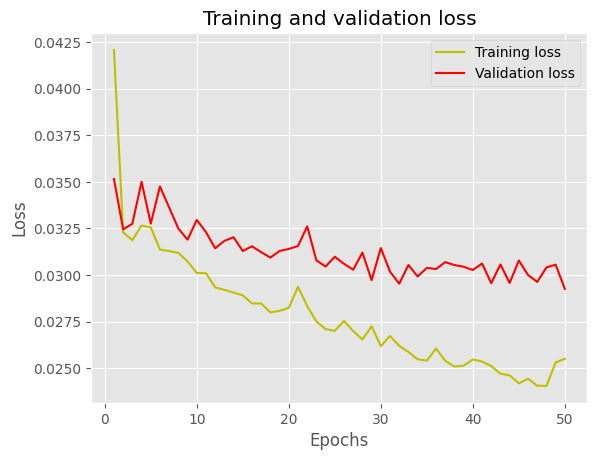

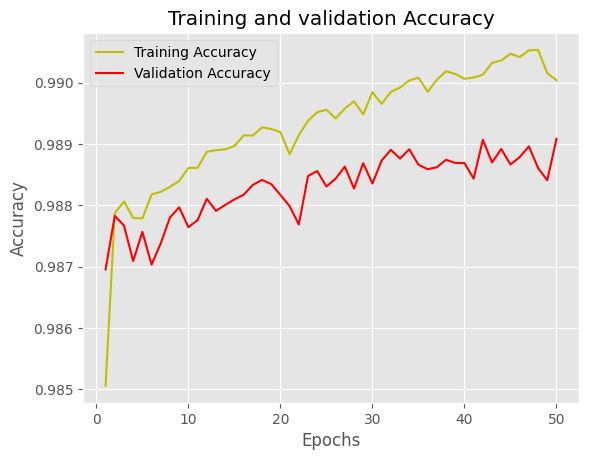

In [76]:
# evaluate model
_, acc = model.evaluate(X_test, y_test_category)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#dice coeff


In [77]:
y_pred=model.predict(X_test) #use current model to predict and segment X_test data
# prediction is in probabilities, and argmax find argument that give max value, find class with max probability
y_pred_argmax=np.argmax(y_pred, axis=3)


4/4 [==============================] - 0s 7ms/step


In [78]:
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        print(f"dice coeff of {index+1} class is : {dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])}")
    return dice/numLabels # taking average

# dice = dice_coef(y_test_category.astype('float32'), y_pred.astype('float32'))
dice = dice_coef_multilabel(y_test_category.astype('float32'), y_pred.astype('float32'), n_classes)
dice = np.array(dice)
print(f"dice coefficient is : {np.mean(dice)}")

dice coeff of 1 class is : 0.998046942071104
dice coeff of 2 class is : 0.9585509459698232
dice coeff of 3 class is : 0.9566214921960832
dice coeff of 4 class is : 0.6566844065900069
dice coeff of 5 class is : 0.9953652524957332
dice coeff of 6 class is : 0.9079499599796248
dice coefficient is : 0.9122031665503959


#calculating intersection over union (IOU)

In [79]:
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes = n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
'''
IOU means the overlap of predicted segment and ground truth over total area
'''
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8867178


IoU for class1 is:  0.997267
IoU for class2 is:  0.94158274
IoU for class3 is:  0.93743175
IoU for class4 is:  0.58295906
IoU for class5 is:  0.9935542
IoU for class6 is:  0.86751235
mean IoU is :  0.8867177963256836


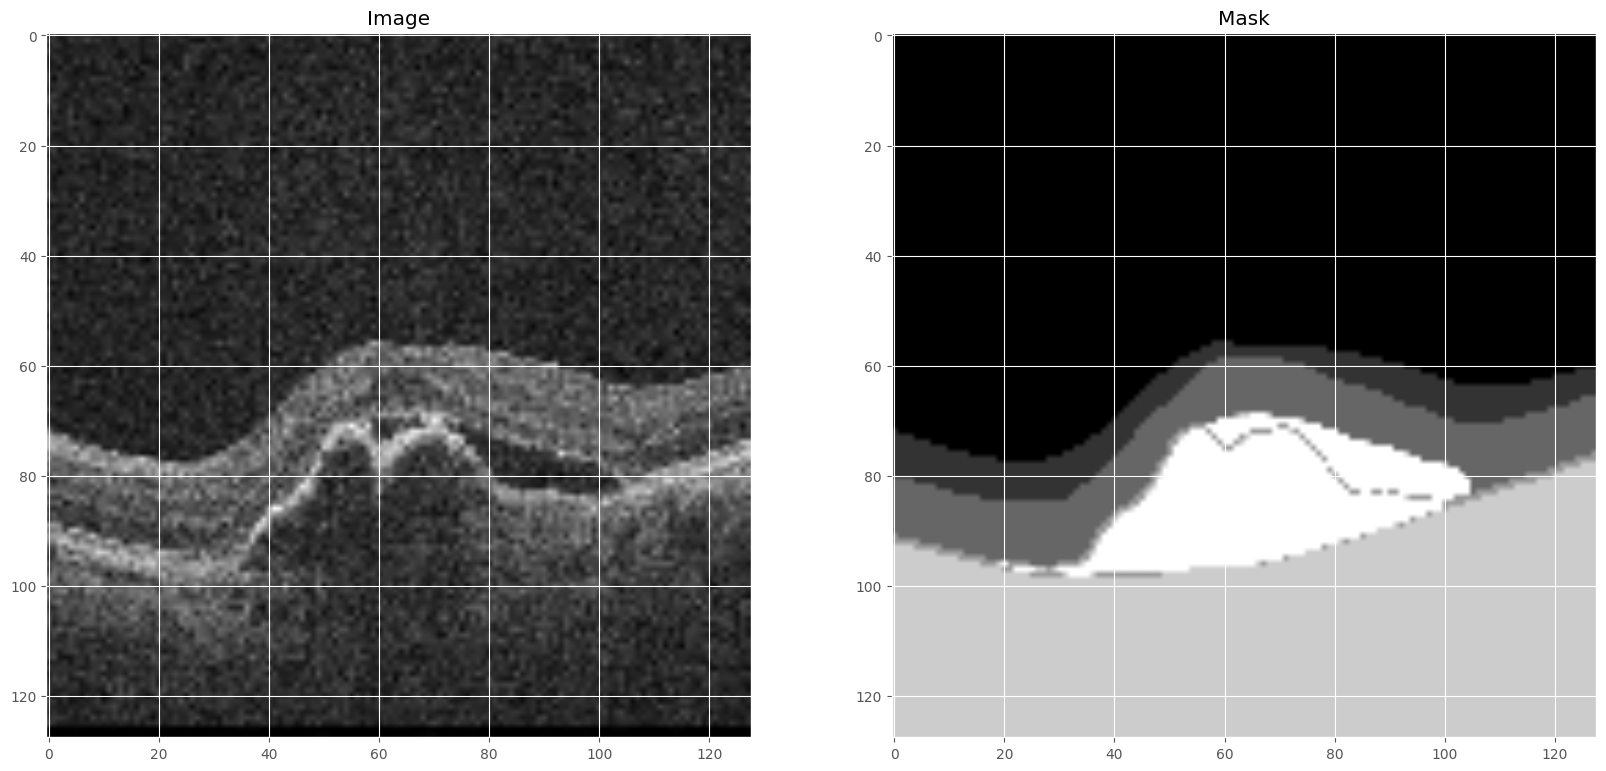

In [80]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("mean IoU is : ", (class1_IoU + class2_IoU + class3_IoU + class4_IoU + class5_IoU + class6_IoU)/6)


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,15))
ax1.set_title("Image")
ax1.imshow(train_images[100,:,:,0], cmap='gray', interpolation = 'bilinear')
ax2.set_title("Mask")  
ax2.imshow(T_mask[100], cmap='gray',interpolation = 'bilinear')

#load random images and predict segments

In [81]:
import random
def random_pic():
    test_img_number = random.randint(0, len(y_test_category))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


1/1 [==============================] - 0s 21ms/step


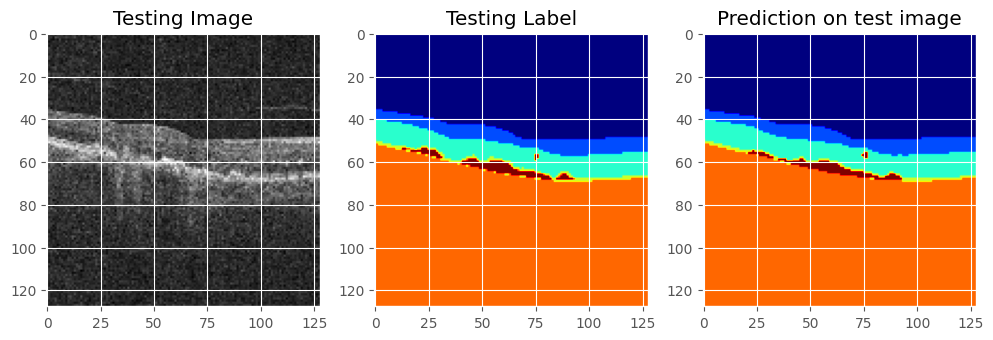

In [82]:
random_pic()

1/1 [==============================] - 0s 27ms/step


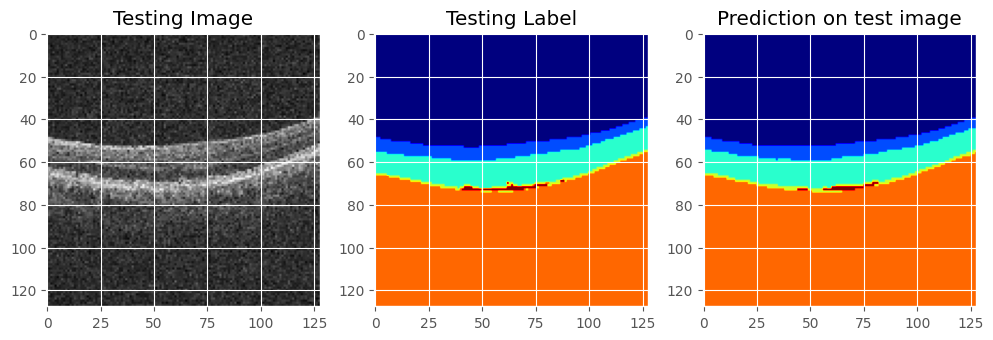

In [83]:
random_pic()

1/1 [==============================] - 0s 22ms/step


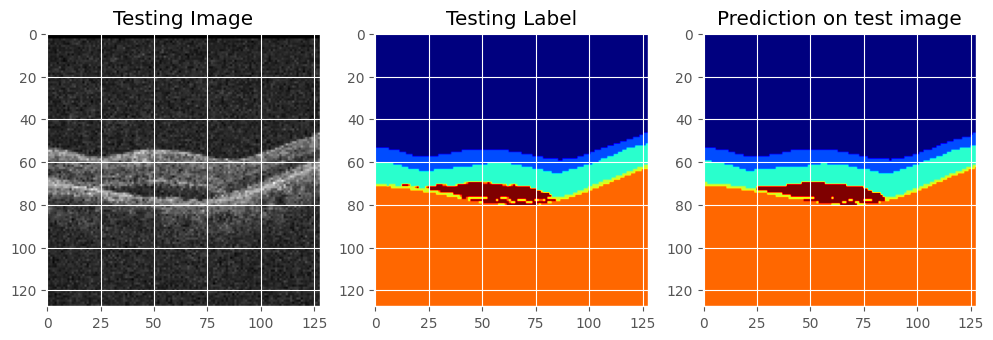

In [84]:
random_pic()

1/1 [==============================] - 0s 22ms/step


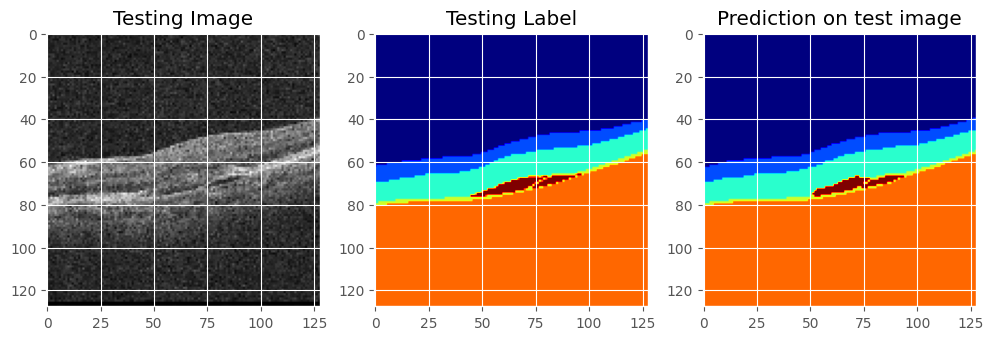

In [85]:
random_pic()

1/1 [==============================] - 0s 22ms/step


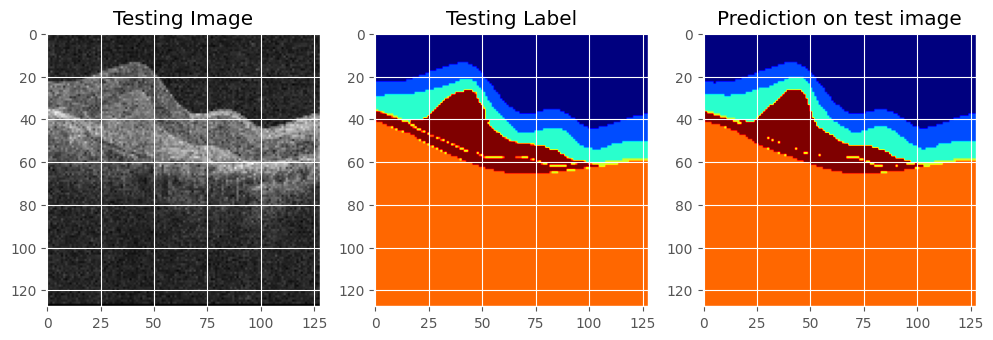

In [89]:
random_pic()